In [1]:
from utils.PandasToolsFunction import *
from utils.DataPreprocessingTools import *
from utils.loss_functions import mean_absolute_percentage_error_np

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestRegressor
import joblib
import os

import matplotlib.pyplot as plt

In [2]:
class RegressorModelPytorch():
    
    """
    Split data per stations to not overcharge memory.
    """

    def __init__(self, train_data: pd.DataFrame, size = 50, 
                regressor_type='RandomForest', n_estimators = 1_000,
                station_col = 'station', features_col = ['week', 'day_numeric', 'day_type'],
                label_col = 'y') -> None:

        self.submission = None
        
        self.size = size 

        self.regressor_type = regressor_type
        self.n_estimators = n_estimators

        self.train_data = train_data
        self.station_col = station_col
        self.features_col = features_col
        self.label_col = label_col

        self.features_dim = len(features_col)

        self.setting_scaler(train_data) # Once and for all.

        # We split the training date per subsets of "size" stations each.
        self.split_dataframes = train_data_station_split(self.train_data, size, station_col)
        self.nb_of_small_data = len(self.split_dataframes)
        
        self.test_scores = {}
        self.train_scores = {}

        # For plot and save
        self.scores_saving_path = f'models/{regressor_type}/Scores/' + f'n_est_{n_estimators}' 
        self.scores_title = f'{regressor_type}, n_estimators : {n_estimators} \n '
    
    def setting_scaler(self, train_data: pd.DataFrame):
                
        # We need to use only one scaler for every station, we fit on one station and we then reuse it for every other. 
        # Be careful to use the same for testing than for training, indeed, as there are not as many weeks on the test, set, the scaling would be different
        # if it is made on the test.set

        self.scaler = MinMaxScaler()
        # Training the scaler once and for all :
        mask = (train_data['station'] == train_data[self.station_col].unique()[0])
        features = train_data[mask][self.features_col]
        _ = self.scaler.fit_transform(features)

    def preprocessing_data(self, small_train_data: pd.DataFrame, test_size = 0.1):

        stations = small_train_data[self.station_col].unique()

        # Creating one model per station. 
        if self.regressor_type =='RandomForest' :
            self.models = {station : RandomForestRegressor(n_estimators=self.n_estimators) for station in stations} 
        
        self.datasets = {} # each dataset will contain four sets : X_train, X_test, Y_train, Y_test

        # creating datasets

        for station in stations :

            station_indices = small_train_data.index[small_train_data[self.station_col] == station]
            features = small_train_data.loc[station_indices, self.features_col]
            y = small_train_data.loc[station_indices, self.label_col]
            # print("TYPE Y", type(y)) # pandas.Series so we have numpy it.
            y = np.array(y)

            X_normalized = self.scaler.transform(features)

            self.datasets[station] = train_test_split(X_normalized, y, test_size=test_size, random_state= 42, shuffle=False)

    def train(self, test_size = 0.1, threshold = 0.1) : 

        for k, small_train_data in tqdm(enumerate(self.split_dataframes), desc="Split dataframes") :
            
            self.preprocessing_data(small_train_data, test_size)
            
            for station, regressor in tqdm(self.models.items(), desc="Stations"):
                
                X_train, X_test, y_train, y_test = self.datasets[station]

                regressor.fit(X_train, y_train)
                
                test_pred = regressor.predict(X_test)
                train_pred = regressor.predict(X_train)

                test_score = mean_absolute_percentage_error_np(y_test, test_pred, threshold)
                train_score = mean_absolute_percentage_error_np(y_train, train_pred, threshold)

                print(f'Station {station}.')
                print(f'Train data size : {len(X_train)}, Test data size : {len(X_test)}')
                print(f'Score on train set : {train_score}, Score on test set : {test_score} \n')

                self.test_scores[station] = test_score
                self.train_scores[station] = train_score

                
    def test(self, test_data: pd.DataFrame):
        
        # Important to keep same size than for training, that is why we put self.size
        test_split_dataframes = train_data_station_split(test_data, self.size, self.station_col)
 
        for k, small_test_data in enumerate(test_split_dataframes):
            
            for station, regressor in self.models.items() :
                station_indices = small_test_data.index[small_test_data[self.station_col] == station]
                features = small_test_data.loc[station_indices, self.features_col]
                X_test_normalized = self.scaler.transform(features)

                y_pred = regressor.predict(X_test_normalized)
                y_pred = np.maximum(y_pred, 0)
                
                # Update the original DataFrame directly
                test_data.loc[station_indices, self.label_col] = y_pred
                          
        self.submission = test_data[['index', 'y']]
        return test_data
    
    def plot_scores(self, subtitle:str, fig_name = None):
        # Both dictionaries have the same keys
        keys = list(self.test_scores.keys())

        test_values = [self.test_scores[key] for key in keys]
        train_values = [self.train_scores[key] for key in keys]
        test_mean = np.mean(test_values)
        train_mean = np.mean(train_values)
      
        plt.plot(keys, test_values, label='Test Scores')
        plt.plot(keys, train_values, label='Train Scores')
        plt.axhline(test_mean, color='r', linestyle='--', label=f'Mean Test Score: {test_mean}')
        plt.axhline(train_mean, color='b', linestyle='--', label=f'Mean Train Score: {train_mean}')

        plt.xlabel('Keys')
        plt.ylabel('Scores')
        
        plt.title(self.scores_title + subtitle )
        plt.legend()

        if fig_name is not None :
            plt.savefig(self.scores_saving_path + fig_name + '.png')

        plt.show()

    def save_submission(self, name = "submission"):
        self.submission.to_csv("submissions/" + name + ".csv", index=False)    

In [3]:
# Charger les données d'entraînement
train_data = pd.read_csv('data/train_data_day_typed_cov_replaced_all_features.csv')
train_data['date'] = pd.to_datetime(train_data['date'])

# Work only on 2019-2022 included
train_data = date_filter(train_data, start_date='2019-12-31', end_date='2022-12-31')

#train_data = date_filter(train_data, start_date='2018-10-20', end_date='2022-12-31')

nb_of_stations = 100
few_stations_filter, stations = make_station_filter(train_data, stations=nb_of_stations, seed = 42)
train_data_few_stations = train_data[few_stations_filter]

Split dataframes: 0it [00:00, ?it/s]

Stations:   0%|          | 0/100 [00:00<?, ?it/s]

Station 033.
Train data size : 780, Test data size : 8
Score on train set : 1.2851454317519844, Score on test set : 0.1661989459154204 

Station 0JU.
Train data size : 780, Test data size : 8
Score on train set : 1.0300716180165816, Score on test set : 0.056997004299066484 

Station 193.
Train data size : 747, Test data size : 8
Score on train set : 0.10433160236095727, Score on test set : 0.1234709899218209 

Station 1EJ.
Train data size : 782, Test data size : 8
Score on train set : 0.01947177694677088, Score on test set : 0.01403932793215697 

Station 1TE.
Train data size : 782, Test data size : 8
Score on train set : 0.10154198303457494, Score on test set : 0.04599892002601859 

Station 23N.
Train data size : 782, Test data size : 8
Score on train set : 0.07417745910625412, Score on test set : 0.047581424040951094 

Station 2AC.
Train data size : 780, Test data size : 8
Score on train set : 0.8968524457612445, Score on test set : 3.836941182926456 

Station 30I.
Train data size : 7

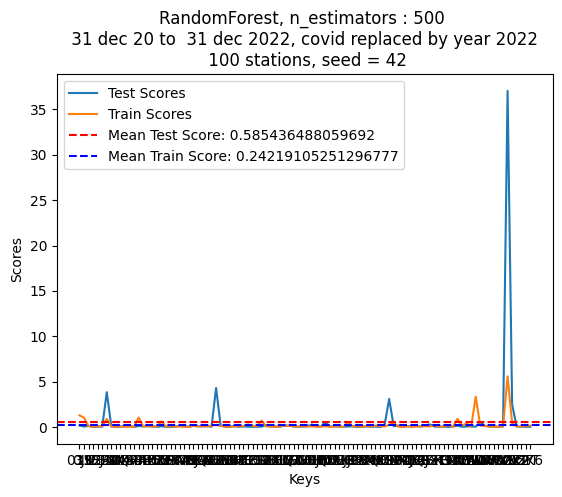

In [5]:
regressor = RegressorModelPytorch(train_data_few_stations, size=nb_of_stations, regressor_type='RandomForest', n_estimators=500)
regressor.train(test_size=0.01)
subtitle = f'31 dec 20 to  31 dec 2022, covid replaced by year 2022 \n {nb_of_stations} stations, seed = 42'
fig_name = '_20121_2022'
regressor.plot_scores(subtitle, fig_name)

# Make a submission

In [15]:
test_data = pd.read_csv('../data/test_data_day_typed_cov_replaced_all_features.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
#one_st_filter2 = make_station_filter(test_data, stations=['1J7'])
#test_data_one_station = test_data[one_st_filter2]

In [16]:
result = regressor.test(test_data)
result

,index,date,week,day_name,day_numeric,station,day_type,y
0,2023-01-01_1J7,2023-01-01,52,Sunday,6,1J7,7,29.613
1,2023-01-01_O2O,2023-01-01,52,Sunday,6,O2O,7,19.384
2,2023-01-01_8QR,2023-01-01,52,Sunday,6,8QR,7,24.169
3,2023-01-01_L58,2023-01-01,52,Sunday,6,L58,7,6.175
4,2023-01-01_UMC,2023-01-01,52,Sunday,6,UMC,7,45.282
...,...,...,...,...,...,...,...,...
78647,2023-05-31_N9K,2023-05-31,22,Wednesday,2,N9K,0,1105.931
78648,2023-05-31_P6E,2023-05-31,22,Wednesday,2,P6E,0,19.970
78649,2023-05-31_BDC,2023-05-31,22,Wednesday,2,BDC,0,21.477
78650,2023-05-31_QD6,2023-05-31,22,Wednesday,2,QD6,0,109.284


In [17]:
regressor.save_submission(name = 'RandomForest1')

In [18]:
regressor.submission

,index,y
0,2023-01-01_1J7,29.613
1,2023-01-01_O2O,19.384
2,2023-01-01_8QR,24.169
3,2023-01-01_L58,6.175
4,2023-01-01_UMC,45.282
...,...,...
78647,2023-05-31_N9K,1105.931
78648,2023-05-31_P6E,19.970
78649,2023-05-31_BDC,21.477
78650,2023-05-31_QD6,109.284
